# BNN using MCMC for predicting Band Gaps 

In [1]:
from pyro.infer import MCMC, NUTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from BNN_basic_model import BayesianNN

from sklearn.preprocessing import StandardScaler
import torch.distributions as dist

# Use predictive distribution
from pyro.infer import Predictive





### Read the data 

In [2]:
df_mp = pd.read_csv('/home/april-ai/Desktop/UQ/MP_Data/materials_data_10k_cleaned.csv')

In [3]:
df_mp = df_mp[(df_mp['band_gap'] > 0.2)]
y = df_mp['band_gap']

### Train-test split

In [4]:
y = df_mp['band_gap'].values
excluded = ["material_id", "composition", "formula_pretty", "symmetry", "structure"]
X = df_mp.drop(excluded, axis=1)

#print("There are {} possible descriptors:\n\n{}".format(X.shape[1], X.columns.values))

print(min(y))

0.200299999999999


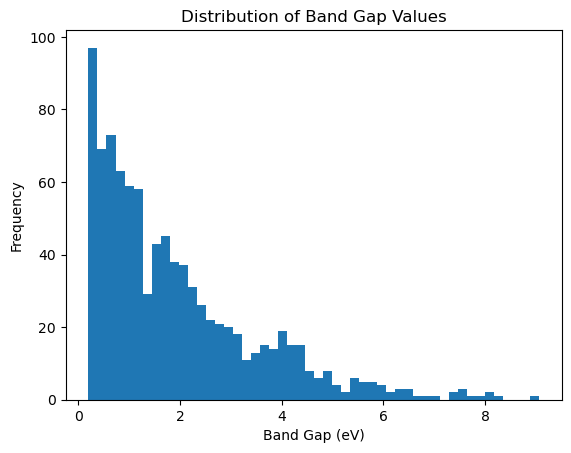

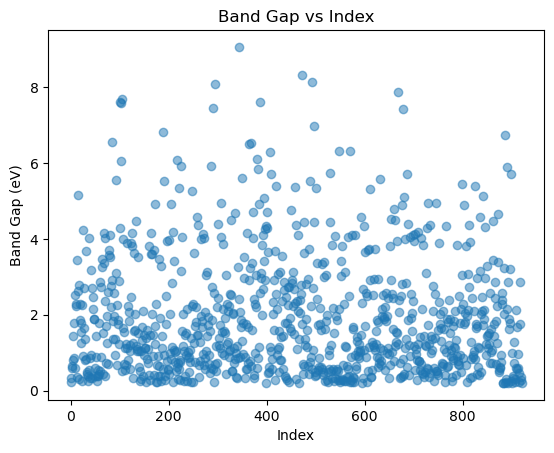

In [5]:
#visualize the distrubution of  the band gap data 

plt.hist(y, bins=50)
plt.xlabel('Band Gap (eV)')
plt.ylabel('Frequency')
plt.title('Distribution of Band Gap Values')
plt.show()

#visualise the bannd gap vs index 
plt.scatter(range(len(y)), y, alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Band Gap (eV)')
plt.title('Band Gap vs Index')
plt.show()

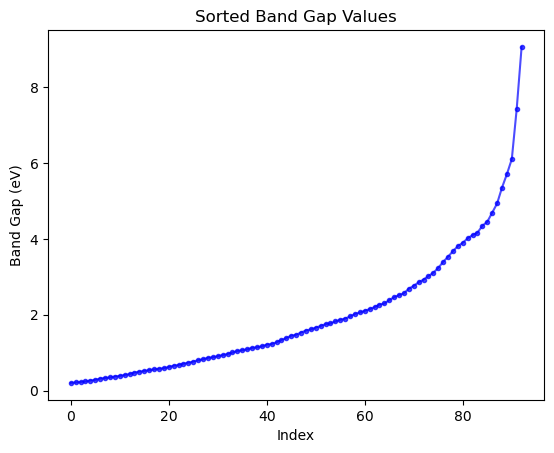

In [6]:
#visualise sorted band gap values
sorted_y = np.sort(y)
plt.plot(sorted_y[: : 10], marker='o', markersize=3, linestyle='-', color='blue', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Band Gap (eV)')
plt.title('Sorted Band Gap Values')
plt.show()

In [7]:
#Train tes split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

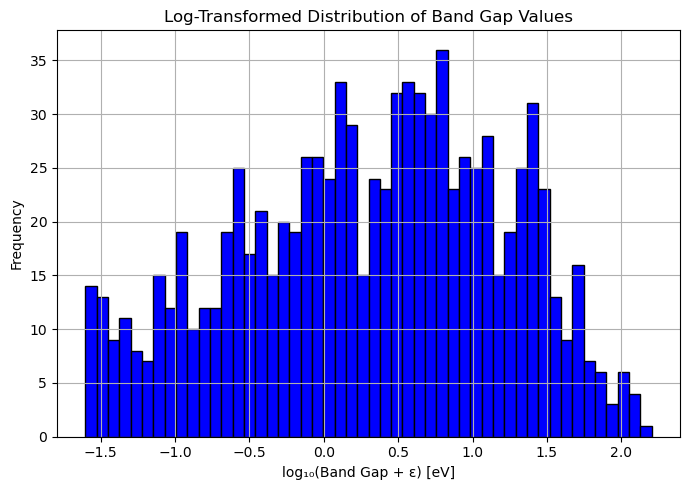

In [8]:
#Log transformed distribution: 
epsilon = 1e-3 #to avoid dividing by zero 
y_log = np.log(y + epsilon)

# Plot histogram of log-transformed band gap values
plt.figure(figsize=(7, 5))
plt.hist(y_log, bins=50, color='blue', edgecolor='black')
plt.xlabel('log₁₀(Band Gap + ε) [eV]')
plt.ylabel('Frequency')
plt.title('Log-Transformed Distribution of Band Gap Values')
plt.grid(True)
plt.tight_layout()
plt.show()


### Data preprocessing

In [9]:

# Drop non-numeric / irrelevant fields
non_feature_cols = [
    "sites", "composition", "formula_pretty", "structure", "symmetry",
    "material_id"
]
df = df_mp.drop(columns=non_feature_cols, errors='ignore')
df = df.dropna(subset=["band_gap"])

# Save original indices
original_indices = np.arange(len(df))

# Split first — before scaling — and keep track of original indices
X_raw = df.drop(columns=["band_gap"])
y_raw = df["band_gap"]

X_train_raw, X_test_raw, y_train_raw, y_test_raw, idx_train, idx_test = train_test_split(
    X_raw, y_raw, original_indices, test_size=0.2, random_state=42
)


y_train_log = np.log(y_train_raw)
y_test_log = np.log(y_test_raw)

In [10]:
print(y_train_log)

1874    0.831256
4262    1.693283
46     -0.098164
180     1.881311
25      0.820176
          ...   
230     0.499016
860    -0.038949
5070   -0.319242
1574    1.049107
206     2.027727
Name: band_gap, Length: 736, dtype: float64


In [11]:
# Normalise training data
scaler_x = StandardScaler()
scaler_y = StandardScaler()


X_train = scaler_x.fit_transform(X_train_raw) #computes mean and std from training data and scales it
X_test = scaler_x.transform(X_test_raw) #uses the same mean and std to scale test data




#y_train = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1)).ravel()
#y_test = scaler_y.transform(y_test_raw.values.reshape(-1, 1)).ravel() #ravel() flattens the output back to 1D, which is typically needed for PyTorch models expecting targets as flat vectors.

y_train = scaler_y.fit_transform(y_train_log.values.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_test_log.values.reshape(-1, 1)).ravel()
# Convert to Pytorch tensors
#C onverts the NumPy arrays into torch.tensor objects, which are the format needed for training/testing the BNN in PyTorch.
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [12]:
print(len(X_train), len(X_test))

736 185


### MCMC Sample and run the model 

In [13]:
import importlib
import BNN_model
importlib.reload(BNN_model)
from BNN_basic_model import BayesianNN

In [14]:
model = BayesianNN(input_dim=X_train.shape[1])  # Initialise BayesianNN model

nuts_kernel = NUTS(model)  # No-U-Turn Sampler — a smart version of Hamiltonian Monte Carlo (HMC) that avoids manually setting path lengths
#=> performs gradient-based MCMC to sample from the posterior distribution over the model parameters, given data.

#Run MCMC 
mcmc = MCMC(nuts_kernel, num_samples=300, warmup_steps=200)
mcmc.run(X_train_tensor, y_train_tensor) #After: 300 samples from the posterior distribution over the weights and biases of the BNN

posterior_samples = mcmc.get_samples() # dictionary of sampled model parameters (e.g., weights, biases)


Sample: 100%|██████████| 500/500 [37:15,  4.47s/it, step size=5.88e-03, acc. prob=0.844]


### Make predictions 

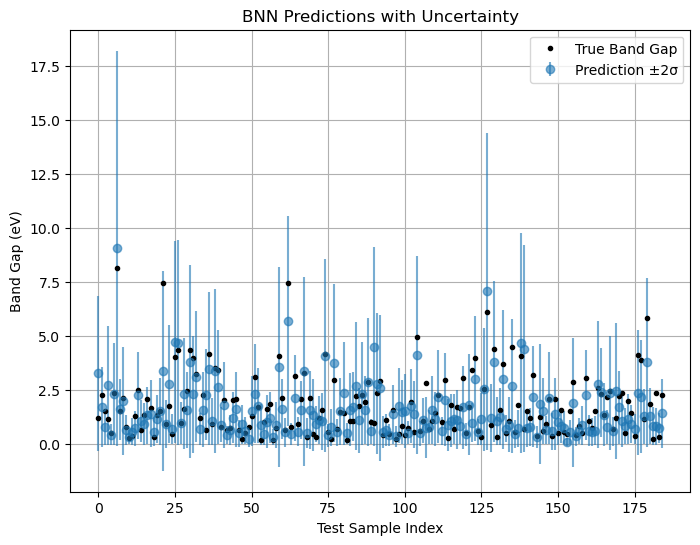

In [15]:


# === Predictive distribution from posterior samples ===
predictive = Predictive(model, posterior_samples, return_sites=["obs"])
preds = predictive(X_test_tensor)["obs"]  # shape: [num_samples, num_test_points]

# === Get predictive mean and std in standardized log space ===
mean_pred = preds.mean(dim=0).numpy()  # [num_test_points]
std_pred = preds.std(dim=0).numpy()

# === Inverse-transform: standardized log → log → actual band gap ===

# Step 1: unstandardize the mean (i.e., bring it back to log space)
mean_pred_log = scaler_y.inverse_transform(mean_pred.reshape(-1, 1)).ravel()

# Step 2: exponentiate to return to original band gap values (eV)
mean_pred_actual = np.exp(mean_pred_log)

# === Adjust uncertainty: transform std back to original units (approximation) ===

# Step 1: unstandardize std — std transforms linearly under scaling
std_pred_log = std_pred * scaler_y.scale_[0]

# Step 2: approximate std in original scale using delta method:
# Var(Y) ≈ (d/dx exp(x))^2 * Var(X) = (exp(mean))^2 * Var(X)
std_pred_actual = mean_pred_actual * std_pred_log  # because d/dx exp(x) = exp(x)

# === Inverse-transform true y values for evaluation/plotting ===
y_test_log = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_test_actual = np.exp(y_test_log)

# Plot with confidence interval
plt.figure(figsize=(8, 6))
plt.errorbar(np.arange(len(mean_pred_actual)), mean_pred_actual, yerr=2*std_pred_actual, fmt='o', label="Prediction ±2σ", alpha=0.6)
plt.plot(np.arange(len(y_test_actual)), y_test_actual, 'k.', label="True Band Gap")
plt.xlabel("Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("BNN Predictions with Uncertainty")
plt.legend()
plt.grid(True)
plt.show()


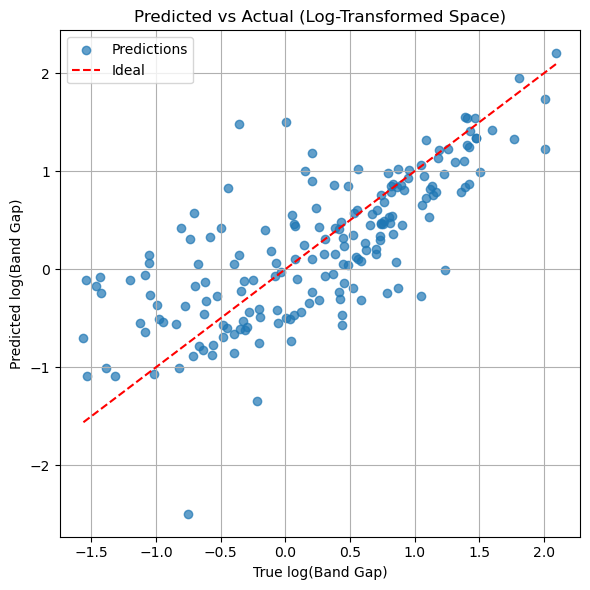

In [16]:
# === Plot: Predicted vs Actual in Log-Transformed Space ===
plt.figure(figsize=(6, 6))
plt.scatter(y_test_log, mean_pred_log, alpha=0.7, label="Predictions")
plt.plot([y_test_log.min(), y_test_log.max()],
         [y_test_log.min(), y_test_log.max()],
         'r--', label="Ideal")  # 45-degree line
plt.xlabel("True log(Band Gap)")
plt.ylabel("Predicted log(Band Gap)")
plt.title("Predicted vs Actual (Log-Transformed Space)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
"""

#getting predictions from the posterior 
predictive = Predictive(model, posterior_samples, return_sites=["obs"]) #Predictive in Pyro uses sample from posterior to generate predictiosn 
#=> return predictions at the "obs" site in the model, which corresponds to the observed outputs (e.g., target band gaps).

#pass X_test_tensor (test inputs as a PyTorch tensor) to the predictive object.
#=> Each row in preds corresponds to predictions from one set of posterior parameters.
preds = predictive(X_test_tensor)["obs"]  # output shape: [num_samples, num_test_points]

mean_pred = preds.mean(dim=0).numpy() #average over the posterior predictive samples — predictive mean, best estimate of the output
std_pred = preds.std(dim=0).numpy() # standard deviation over the predictive samples — epistemic uncertainty

# Inverse-transform band gaps
#converts the predicted means back to the original scale (eV) from being scaled using StandardScaler
mean_pred_actual = scaler_y.inverse_transform(mean_pred.reshape(-1, 1)).ravel()

#adjust the predicted uncertainty to match the units of the original data.
std_pred_actual = std_pred * scaler_y.scale_[0]  # std scales linearly

#convert the standardized y_test targets back to the original scale, for comparison with predictions.
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()#
"""

'\n\n#getting predictions from the posterior \npredictive = Predictive(model, posterior_samples, return_sites=["obs"]) #Predictive in Pyro uses sample from posterior to generate predictiosn \n#=> return predictions at the "obs" site in the model, which corresponds to the observed outputs (e.g., target band gaps).\n\n#pass X_test_tensor (test inputs as a PyTorch tensor) to the predictive object.\n#=> Each row in preds corresponds to predictions from one set of posterior parameters.\npreds = predictive(X_test_tensor)["obs"]  # output shape: [num_samples, num_test_points]\n\nmean_pred = preds.mean(dim=0).numpy() #average over the posterior predictive samples — predictive mean, best estimate of the output\nstd_pred = preds.std(dim=0).numpy() # standard deviation over the predictive samples — epistemic uncertainty\n\n# Inverse-transform band gaps\n#converts the predicted means back to the original scale (eV) from being scaled using StandardScaler\nmean_pred_actual = scaler_y.inverse_transfo

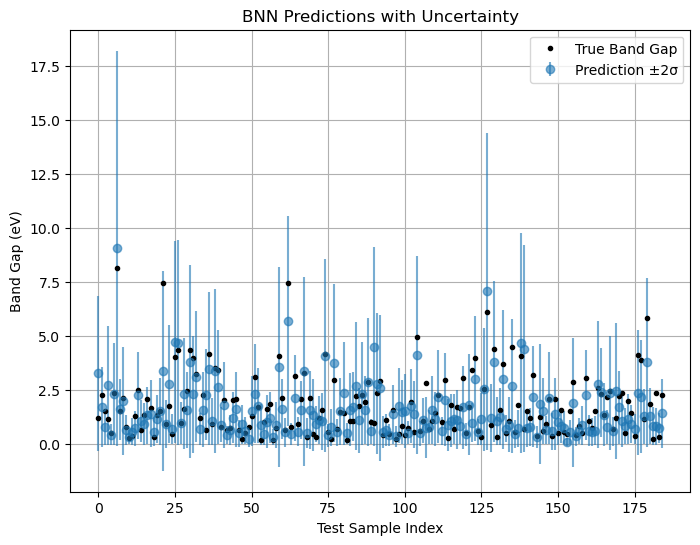

In [18]:
plt.figure(figsize=(8, 6))
plt.errorbar(np.arange(len(mean_pred_actual)), mean_pred_actual, yerr=2*std_pred_actual, fmt='o', label="Prediction ±2σ", alpha=0.6)
plt.plot(np.arange(len(y_test_actual)), y_test_actual, 'k.', label="True Band Gap")
plt.xlabel("Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("BNN Predictions with Uncertainty")
plt.legend()
plt.grid(True)
plt.show()


#### Compute log-likelihood

For original data: 

In [19]:
"""
test_preds = predictive(X_test_tensor)["obs"]  # shape: [num_samples, num_test_points]

# Mean and std from posterior predictive samples
mean_pred = test_preds.mean(dim=0)
std_pred = test_preds.std(dim=0) + 1e-6  # avoid log(0)

# Assume Gaussian predictive distribution
likelihood = dist.Normal(mean_pred, std_pred)

# Convert true y_test values (already standardized) to tensor
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Compute log-probability of true values under the predictive distribution
log_probs = likelihood.log_prob(y_test_tensor)  # shape: [num_test_points]

# Compute total and average log-likelihood
log_likelihood_total = log_probs.sum().item()
log_likelihood_avg = log_probs.mean().item()
nll = -log_likelihood_total
nll_avg = -log_likelihood_avg

print(f"Total Log-Likelihood (Test): {log_likelihood_total:.2f}")
print(f"Average Log-Likelihood per Sample: {log_likelihood_avg:.4f}")
print(f"Negative Log-Likelihood (NLL): {nll:.2f}")
print(f"Average NLL per Sample: {nll_avg:.4f}")

#Get all posterior predictive samples for train and test
predictive = Predictive(model, posterior_samples, return_sites=["obs"])
train_preds = predictive(X_train_tensor)["obs"]  # shape: [num_samples, num_train_points]
test_preds = predictive(X_test_tensor)["obs"]    # shape: [num_samples, num_test_points]

# Compute mean and std for each data point across posterior samples
train_mean = train_preds.mean(dim=0)
train_std = train_preds.std(dim=0) + 1e-6
test_mean = test_preds.mean(dim=0)
test_std = test_preds.std(dim=0) + 1e-6

# Compute NLL for each data point
train_likelihood = dist.Normal(train_mean, train_std)
test_likelihood = dist.Normal(test_mean, test_std)

# Ensure targets are tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Log-probabilities for each data point
train_log_probs = train_likelihood.log_prob(y_train_tensor)
test_log_probs = test_likelihood.log_prob(y_test_tensor)

# Average NLL
train_nll = -train_log_probs.mean().item()
test_nll = -test_log_probs.mean().item()

# Plot
plt.figure(figsize=(6, 5))
plt.bar(['Train NLL', 'Test NLL'], [train_nll, test_nll], color=['blue', 'orange'])
plt.ylabel("Average Negative Log-Likelihood")
plt.title("BNN Average NLL (Posterior Predictive)")
plt.grid(axis='y')
plt.show()

print(f"Average Train NLL: {train_nll:.4f}")
print(f"Average Test NLL: {test_nll:.4f}")
"""

'\ntest_preds = predictive(X_test_tensor)["obs"]  # shape: [num_samples, num_test_points]\n\n# Mean and std from posterior predictive samples\nmean_pred = test_preds.mean(dim=0)\nstd_pred = test_preds.std(dim=0) + 1e-6  # avoid log(0)\n\n# Assume Gaussian predictive distribution\nlikelihood = dist.Normal(mean_pred, std_pred)\n\n# Convert true y_test values (already standardized) to tensor\ny_test_tensor = torch.tensor(y_test, dtype=torch.float32)\n\n# Compute log-probability of true values under the predictive distribution\nlog_probs = likelihood.log_prob(y_test_tensor)  # shape: [num_test_points]\n\n# Compute total and average log-likelihood\nlog_likelihood_total = log_probs.sum().item()\nlog_likelihood_avg = log_probs.mean().item()\nnll = -log_likelihood_total\nnll_avg = -log_likelihood_avg\n\nprint(f"Total Log-Likelihood (Test): {log_likelihood_total:.2f}")\nprint(f"Average Log-Likelihood per Sample: {log_likelihood_avg:.4f}")\nprint(f"Negative Log-Likelihood (NLL): {nll:.2f}")\npri

For log-transformed data 

Average Train NLL: 0.5475
Average Test NLL: 0.9426
Total Train Log-Likelihood: -402.95
Total Test Log-Likelihood: -174.39


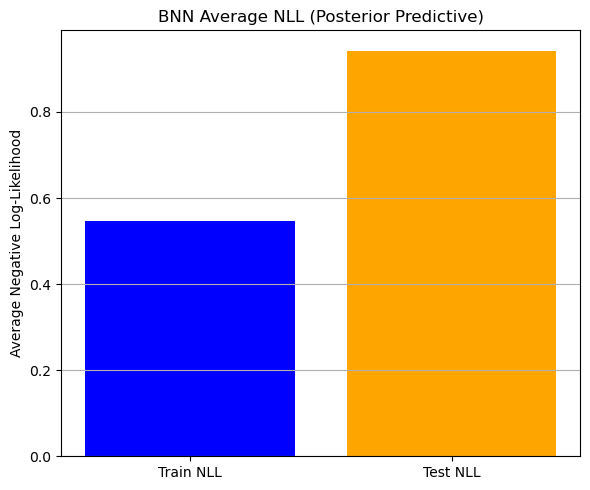

In [20]:
# Ensure targets are tensors (in standardized log space)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Get all posterior predictive samples for train and test
predictive = Predictive(model, posterior_samples, return_sites=["obs"])
train_preds = predictive(X_train_tensor)["obs"]  # shape: [num_samples, num_train_points]
test_preds = predictive(X_test_tensor)["obs"]    # shape: [num_samples, num_test_points]

# Compute mean and std for each point across posterior samples
train_mean = train_preds.mean(dim=0)
train_std = train_preds.std(dim=0).clamp(min=1e-6)  # avoid numerical issues
test_mean = test_preds.mean(dim=0)
test_std = test_preds.std(dim=0).clamp(min=1e-6)

# Predictive Normal distributions
train_likelihood = dist.Normal(train_mean, train_std)
test_likelihood = dist.Normal(test_mean, test_std)

# Log-probabilities for each data point
train_log_probs = train_likelihood.log_prob(y_train_tensor)
test_log_probs = test_likelihood.log_prob(y_test_tensor)

# === Compute NLL
train_nll = -train_log_probs.mean().item()
test_nll = -test_log_probs.mean().item()

# Total log-likelihoods (optional)
total_train_ll = train_log_probs.sum().item()
total_test_ll = test_log_probs.sum().item()

# === Print results
print(f"Average Train NLL: {train_nll:.4f}")
print(f"Average Test NLL: {test_nll:.4f}")
print(f"Total Train Log-Likelihood: {total_train_ll:.2f}")
print(f"Total Test Log-Likelihood: {total_test_ll:.2f}")

# === Plot NLL comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.bar(['Train NLL', 'Test NLL'], [train_nll, test_nll], color=['blue', 'orange'])
plt.ylabel("Average Negative Log-Likelihood")
plt.title("BNN Average NLL (Posterior Predictive)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

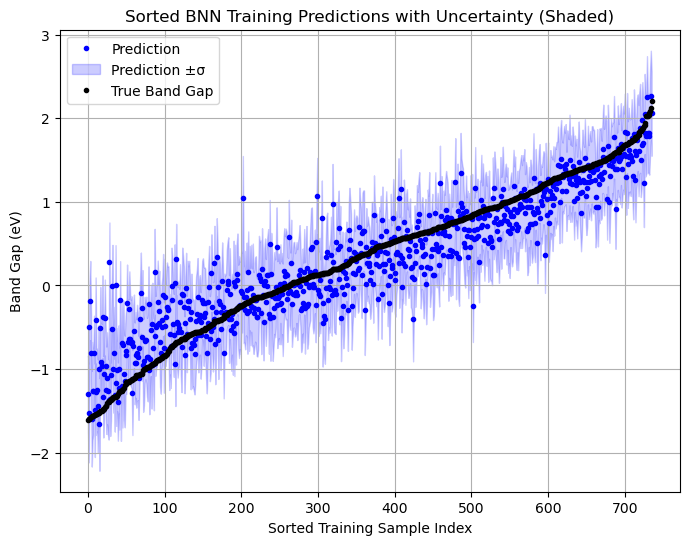

In [21]:
# Get posterior predictions on training data
preds_train = predictive(X_train_tensor)["obs"]
mean_pred_train = preds_train.mean(dim=0).numpy()
std_pred_train = preds_train.std(dim=0).numpy()

# Inverse-transform
mean_pred_train_actual = scaler_y.inverse_transform(mean_pred_train.reshape(-1, 1)).ravel()
std_pred_train_actual = std_pred_train * scaler_y.scale_[0]
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).ravel()

# Sort by true values for plotting
sorted_indices = np.argsort(y_train_actual)
sorted_mean_pred_actual = mean_pred_train_actual[sorted_indices]
sorted_std_pred_actual = std_pred_train_actual[sorted_indices]
sorted_y_train_actual = y_train_actual[sorted_indices]

# Compute bounds for uncertainty region (±1σ or use ±2σ if preferred)
x = np.arange(len(sorted_mean_pred_actual))
upper = sorted_mean_pred_actual + sorted_std_pred_actual
lower = sorted_mean_pred_actual - sorted_std_pred_actual

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x, sorted_mean_pred_actual, 'b.', label="Prediction")
plt.fill_between(x, lower, upper, color='blue', alpha=0.2, label="Prediction ±σ")
plt.plot(x, sorted_y_train_actual, 'k.', label="True Band Gap")
plt.xlabel("Sorted Training Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("Sorted BNN Training Predictions with Uncertainty (Shaded)")
plt.legend()
plt.grid(True)
plt.show()


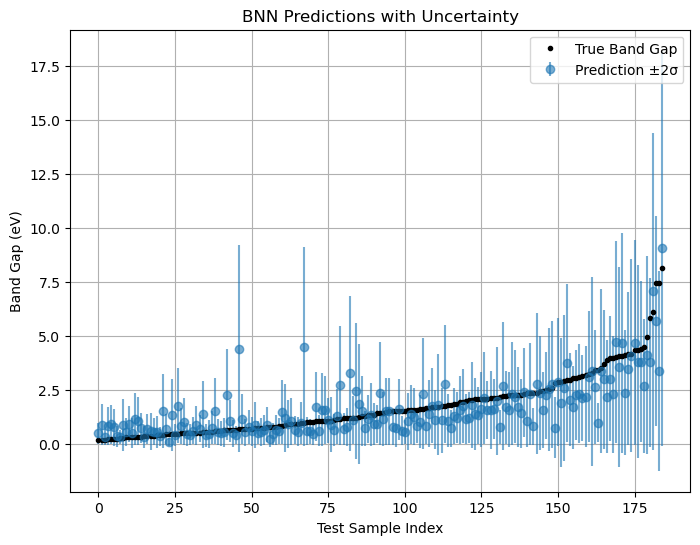

In [22]:
sorted_indices = np.argsort(y_test_actual)
sorted_y_test_actual = y_test_actual[sorted_indices]
sorted_mean_pred_actual = mean_pred_actual[sorted_indices]
sorted_std_pred_actual = std_pred_actual[sorted_indices]
# Plot with confidence interval
plt.figure(figsize=(8, 6))
plt.errorbar(np.arange(len(sorted_mean_pred_actual)), sorted_mean_pred_actual, yerr=2*sorted_std_pred_actual, fmt='o', label="Prediction ±2σ", alpha=0.6)
plt.plot(np.arange(len(sorted_y_test_actual)), sorted_y_test_actual, 'k.', label="True Band Gap")
plt.xlabel("Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("BNN Predictions with Uncertainty")
plt.legend()
plt.grid(True)
plt.show()

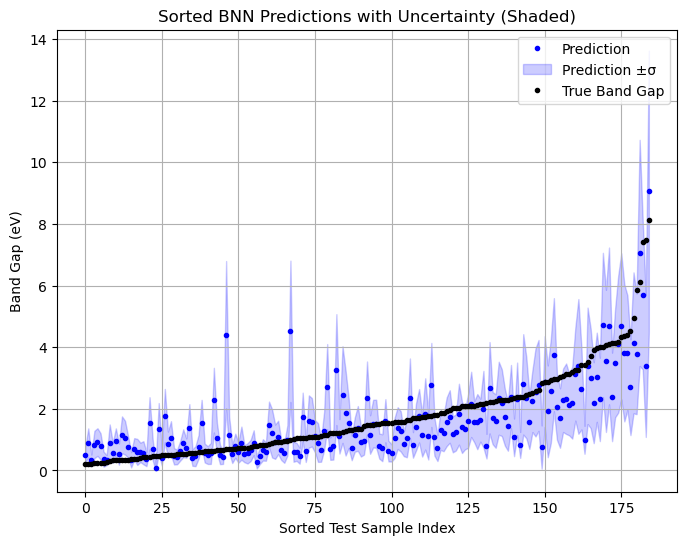

In [23]:
x = np.arange(len(sorted_mean_pred_actual))
upper = sorted_mean_pred_actual + sorted_std_pred_actual
lower = sorted_mean_pred_actual - sorted_std_pred_actual

plt.figure(figsize=(8, 6))
plt.plot(x, sorted_mean_pred_actual, 'b.', label="Prediction")
plt.fill_between(x, lower, upper, color='blue', alpha=0.2, label="Prediction ±σ")
plt.plot(x, sorted_y_test_actual, 'k.', label="True Band Gap")
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("Sorted BNN Predictions with Uncertainty (Shaded)")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
#get information about outliers 
outliers = np.abs(sorted_mean_pred_actual - sorted_y_test_actual) > 1.5 # Define outliers as those with a difference greater than 0.2 eV
outlier_indices = np.where(outliers)[0]
sorted_y_test_actual = y_test_actual[sorted_indices]
sorted_mean_pred_actual = mean_pred_actual[sorted_indices]
print("Outlier Indices:", outlier_indices)
print("Outlier Predictions:", sorted_mean_pred_actual[outlier_indices])
print("Outlier True Values:", sorted_y_test_actual[outlier_indices])


Outlier Indices: [ 42  46  67  79  82 142 149 163 166 168 172 178 180 182 183]
Outlier Predictions: [2.2807672 4.4059935 4.515353  2.7201786 3.2724657 0.8286945 0.7581653
 0.9938716 2.1992385 2.3050072 2.386021  2.699694  3.7841086 5.6994944
 3.3972807]
Outlier True Values: [0.6412 0.6975 1.0035 1.165  1.2267 2.3853 2.8504 3.4296 3.8943 4.007
 4.1443 4.5103 5.8537 7.4289 7.4639]


In [25]:
outlier_test_indices = sorted_indices[outlier_indices]

In [26]:
# Map test index to original DataFrame index
outlier_original_indices = idx_test[outlier_test_indices]


#### Plot shading ±1 standard deviation (σ) (68% confidence)

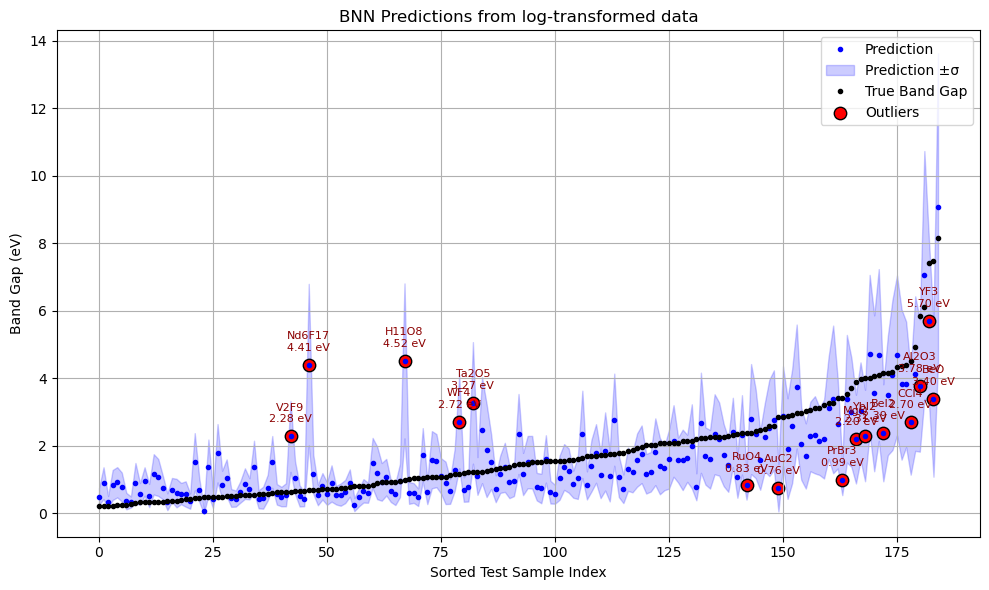

In [27]:
# Map sorted → test → original index
outlier_test_indices = sorted_indices[outlier_indices]
outlier_original_indices = idx_test[outlier_test_indices]

# Get pretty formulas from original dataset
formulas = df_mp.iloc[outlier_original_indices]["formula_pretty"].values

# Plot predictions and uncertainty
x = np.arange(len(sorted_mean_pred_actual))
errors = np.abs(sorted_mean_pred_actual - sorted_y_test_actual)
outlier_mask = errors > 1.5
outlier_indices = np.where(outlier_mask)[0]
outlier_preds = sorted_mean_pred_actual[outlier_indices]

plt.figure(figsize=(10, 6))
plt.plot(x, sorted_mean_pred_actual, 'b.', label="Prediction")
plt.fill_between(x, lower, upper, color='blue', alpha=0.2, label="Prediction ±σ")
plt.plot(x, sorted_y_test_actual, 'k.', label="True Band Gap")
plt.scatter(x[outlier_indices], outlier_preds, color='red', edgecolor='black', s=80, label='Outliers')

# Annotate each outlier with formula and predicted band gap
for i, idx in enumerate(outlier_indices):
    pred_val = sorted_mean_pred_actual[idx]
    formula = formulas[i]
    plt.annotate(
        f"{formula}\n{pred_val:.2f} eV",
        (x[idx], pred_val),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=8,
        color='darkred'
    )

# Formatting
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("BNN Predictions from log-transformed data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



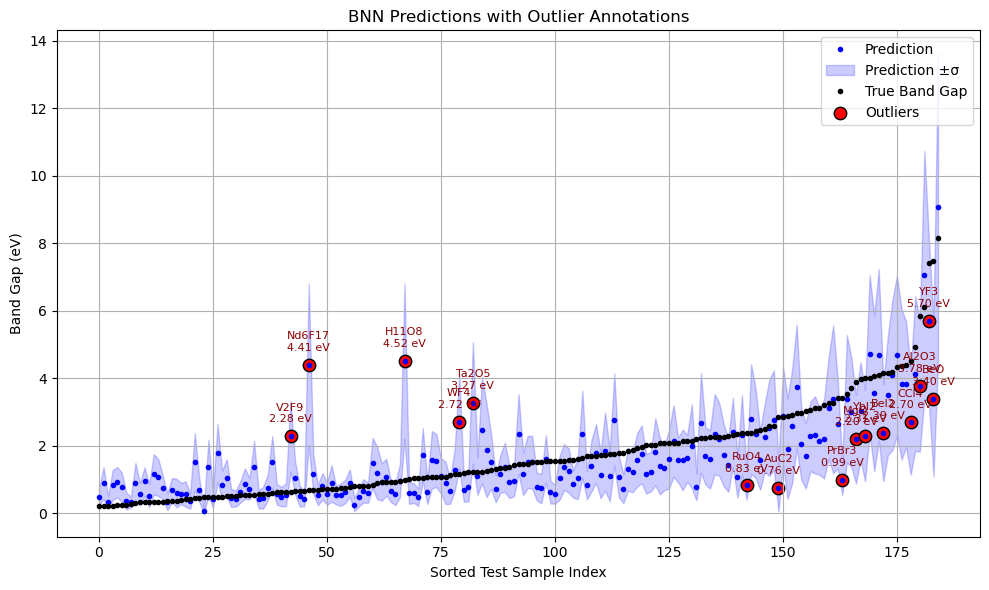

In [32]:
# Sort both arrays using the same indices
sorted_indices = np.argsort(y_test_actual)
sorted_y_test_actual = y_test_actual[sorted_indices]
sorted_mean_pred_actual = mean_pred_actual[sorted_indices]
sorted_std_pred_actual = std_pred_actual[sorted_indices]

# Now you can safely subtract
errors = np.abs(sorted_mean_pred_actual - sorted_y_test_actual)
outlier_mask = errors > 1.5  # > 1.5 eV difference is considered an outlier
outlier_indices = np.where(outlier_mask)[0]  # indices in the sorted array
outlier_preds = sorted_mean_pred_actual[outlier_indices]

# === Map sorted test indices → original dataset row indices ===
outlier_test_indices = sorted_indices[outlier_indices]           # in X_test
outlier_original_indices = idx_test[outlier_test_indices]        # in df_mp

# === Retrieve formulas using original indices ===
formulas = df_mp.iloc[outlier_original_indices]["formula_pretty"].values

# === Plot predictions with uncertainty and annotate outliers ===
x = np.arange(len(sorted_mean_pred_actual))
upper = sorted_mean_pred_actual + sorted_std_pred_actual
lower = sorted_mean_pred_actual - sorted_std_pred_actual

plt.figure(figsize=(10, 6))
plt.plot(x, sorted_mean_pred_actual, 'b.', label="Prediction")
plt.fill_between(x, lower, upper, color='blue', alpha=0.2, label="Prediction ±σ")
plt.plot(x, sorted_y_test_actual, 'k.', label="True Band Gap")
plt.scatter(x[outlier_indices], outlier_preds, color='red', edgecolor='black', s=80, label='Outliers')

# Annotate outliers
for i, idx in enumerate(outlier_indices):
    pred_val = sorted_mean_pred_actual[idx]
    formula = formulas[i]
    plt.annotate(
        f"{formula}\n{pred_val:.2f} eV",
        (x[idx], pred_val),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=8,
        color='darkred'
    )

# === Plot formatting ===
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("BNN Predictions with Outlier Annotations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


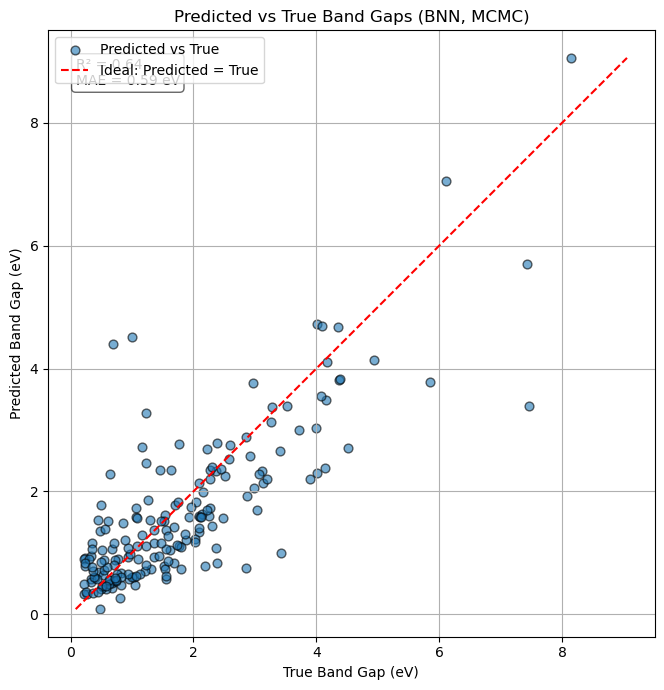

In [33]:
# mean_pred_actual: predicted mean band gaps (already inverse-transformed to eV)
# y_test_actual: true band gaps (already inverse-transformed to eV)

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

# Calculate stats
r2 = r2_score(y_test_actual, mean_pred_actual)
mae = mean_absolute_error(y_test_actual, mean_pred_actual)

# Determine axis limits with padding
min_val = min(y_test_actual.min(), mean_pred_actual.min())
max_val = max(y_test_actual.max(), mean_pred_actual.max())
padding = (max_val - min_val) * 0.05

# Create plot
plt.figure(figsize=(7, 7))
plt.scatter(y_test_actual, mean_pred_actual, alpha=0.6, s=40, edgecolor='k', label="Predicted vs True")

# Plot ideal prediction line
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal: Predicted = True")

# Axis labels and title
plt.xlabel("True Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title("Predicted vs True Band Gaps (BNN, MCMC)")

# Set limits and equal aspect ratio
plt.xlim(min_val - padding, max_val + padding)
plt.ylim(min_val - padding, max_val + padding)
plt.gca().set_aspect('equal', adjustable='box')

# Annotate with R² and MAE
plt.text(min_val, max_val, f"R² = {r2:.2f}\nMAE = {mae:.2f} eV",
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.6))

# Final touches
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
#Compute absolute error and define outliers
errors = np.abs(sorted_mean_pred_actual - sorted_y_test_actual)
outlier_mask = errors > 1.5  # Define your outlier threshold here
outlier_indices_sorted = np.where(outlier_mask)[0]

# Map sorted index → test index → original dataset index
outlier_test_indices = sorted_indices[outlier_indices_sorted]
outlier_original_indices = idx_test[outlier_test_indices]

#Extract info from the original DataFrame
compositions = df_mp.iloc[outlier_original_indices]["formula_pretty"].values
true_bandgaps = sorted_y_test_actual[outlier_indices_sorted]
predicted_bandgaps = sorted_mean_pred_actual[outlier_indices_sorted]

#Build the summary table
outliers_df = pd.DataFrame({
    "outlier_index": outlier_indices,
    "original_index": outlier_original_indices,
    "formula": compositions,
    "true_band_gap": true_bandgaps,
    "predicted_band_gap": predicted_bandgaps, 
    "absolute error": predicted_bandgaps - true_bandgaps

})


print(outliers_df.sort_values(by="true_band_gap"))


    outlier_index  original_index formula  true_band_gap  predicted_band_gap  \
0              42             757    V2F9         0.6412            2.280767   
1              46             790  Nd6F17         0.6975            4.405993   
2              67             765   H11O8         1.0035            4.515353   
3              79             296     WF4         1.1650            2.720179   
4              82             319   Ta2O5         1.2267            3.272466   
5             142             467    RuO4         2.3853            0.828695   
6             149             916    AuC2         2.8504            0.758165   
7             163             394   PrBr3         3.4296            0.993872   
8             166             751     MgO         3.8943            2.199239   
9             168             107    YbI2         4.0070            2.305007   
10            172             360    BeI2         4.1443            2.386021   
11            178             327    CCl

#### Plot shading 95% confidence interval 

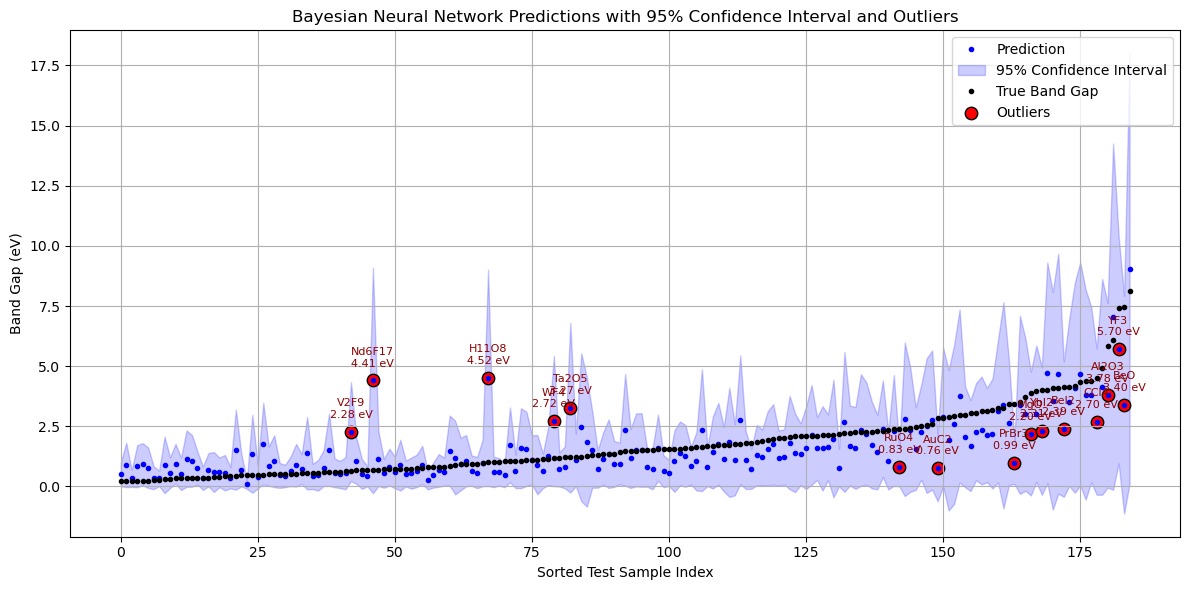

In [36]:
# Define 95% confidence interval bounds (assuming normal distribution)
lower = sorted_mean_pred_actual - 1.96 * sorted_std_pred_actual
upper = sorted_mean_pred_actual + 1.96 * sorted_std_pred_actual

# Compute absolute prediction errors
errors = np.abs(sorted_mean_pred_actual - sorted_y_test_actual)

# Identify outliers with error > 1.5 eV
outlier_mask = errors > 1.5
outlier_indices = np.where(outlier_mask)[0]
outlier_preds = sorted_mean_pred_actual[outlier_indices]

# Map sorted → test → original index
outlier_test_indices = sorted_indices[outlier_indices]
outlier_original_indices = idx_test[outlier_test_indices]

# Get chemical formulas for outliers from original dataframe
formulas = df_mp.iloc[outlier_original_indices]["formula_pretty"].values

# X-axis: just indices of sorted test points
x = np.arange(len(sorted_mean_pred_actual))

# Plot
plt.figure(figsize=(12, 6))

# Mean prediction
plt.plot(x, sorted_mean_pred_actual, 'b.', label="Prediction")

# 95% Confidence interval
plt.fill_between(x, lower, upper, color='blue', alpha=0.2, label="95% Confidence Interval")

# True values
plt.plot(x, sorted_y_test_actual, 'k.', label="True Band Gap")

# Outliers
plt.scatter(x[outlier_indices], outlier_preds, color='red', edgecolor='black', s=80, label='Outliers')


# Annotate outliers with formula and prediction
for i, idx in enumerate(outlier_indices):
    pred_val = sorted_mean_pred_actual[idx]
    formula = formulas[i]
    plt.annotate(
        f"{formula}\n{pred_val:.2f} eV",
        (x[idx], pred_val),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=8,
        color='darkred'
    )


# Formatting
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("Bayesian Neural Network Predictions with 95% Confidence Interval and Outliers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
